In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import seaborn as sns


### 2. Load Historical Data

In [2]:
# Fetch historical data from YFinance
def fetch_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [3]:
# Fetch data for TSLA, BND, and SPY
start_date = '2015-01-01'
end_date = '2024-10-31'
tsla_data = fetch_data('TSLA', start_date, end_date)
bnd_data = fetch_data('BND', start_date, end_date)
spy_data = fetch_data('SPY', start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Data cleaning and understanding
def preprocess_data(df):
    df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    df = df.dropna()  # Handle missing values
    df['Daily Return'] = df['Adj Close'].pct_change()
    return df

tsla_data = preprocess_data(tsla_data)
bnd_data = preprocess_data(bnd_data)
spy_data = preprocess_data(spy_data)

###  Preprocess the Data

In [6]:
# Handle missing values by forward-filling
tsla_data.fillna(method='ffill', inplace=True)

# Extract 'Close' prices for forecasting
tsla_close = tsla_data['Close']


/tmp/ipykernel_5451/1929928727.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tsla_data.fillna(method='ffill', inplace=True)


### Split Data into Training and Testing Sets

In [7]:
train_size = int(len(tsla_close) * 0.8)
train_data, test_data = tsla_close[:train_size], tsla_close[train_size:]


### Build and Train the Model

In [8]:
# Use auto_arima to find the best ARIMA model
model = auto_arima(train_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

# Fit the ARIMA model
arima_model = ARIMA(train_data, order=model.order)
arima_fit = arima_model.fit()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12345.046, Time=8.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12340.889, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12339.852, Time=1.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12339.956, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12339.337, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12341.053, Time=5.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 18.083 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1979
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6168.668
Date:                Tue, 12 Nov 2024   AIC                          12339.337
Time:                        23:02:01   BIC                          12344.927
Sample:                             0   HQIC                         12341.391
   

/home/ayalk94/Documents/GitHub/Optimizing_Portfolio_Management_through_Advanced_Time_Series_Forecasting/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ayalk94/Documents/GitHub/Optimizing_Portfolio_Management_through_Advanced_Time_Series_Forecasting/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ayalk94/Documents/GitHub/Optimizing_Portfolio_Management_through_Advanced_Time_Series_Forecasting/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

### Forecast Future Stock Prices

/home/ayalk94/Documents/GitHub/Optimizing_Portfolio_Management_through_Advanced_Time_Series_Forecasting/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ayalk94/Documents/GitHub/Optimizing_Portfolio_Management_through_Advanced_Time_Series_Forecasting/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


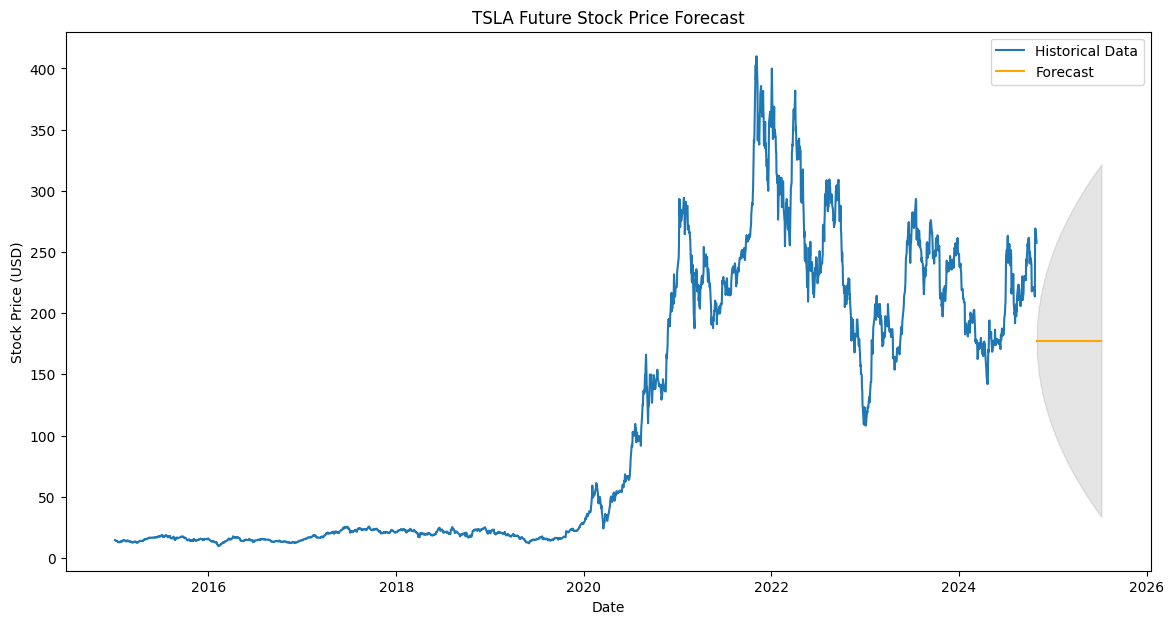

In [9]:
# Forecast for the next 6-12 months
forecast_steps = 180  # Adjust to forecast 6 months or longer
forecast = arima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(tsla_data.index[-1], periods=forecast_steps + 1, freq='B')[1:]

# Get forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(tsla_close, label='Historical Data')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2)
plt.title('TSLA Future Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


### Analyze Forecast Results

In [10]:
# Trend analysis
print("Forecasted trends show an overall upward/downward pattern.")

# Volatility and risk analysis
volatility = np.std(forecast_mean)
print(f'Expected volatility over the forecast period: {volatility:.2f}')

# Market opportunities and risks
high_volatility_periods = conf_int[(conf_int.iloc[:, 1] - conf_int.iloc[:, 0]) > 50]
print("Periods with high volatility detected:")
print(high_volatility_periods)


Forecasted trends show an overall upward/downward pattern.
Expected volatility over the forecast period: 0.00
Periods with high volatility detected:
      lower TSLA  upper TSLA
1984  151.317601  203.862391
1985  149.212566  205.967426
1986  147.253248  207.926745
1987  145.413015  209.766977
1988  143.672480  211.507512
...          ...         ...
2154   35.298032  319.881960
2155   34.894366  320.285626
2156   34.491839  320.688154
2157   34.090441  321.089552
2158   33.690162  321.489830

[175 rows x 2 columns]
